# Unit 5 - Financial Planning

In [3]:
# Initial imports
import os
import requests
import pandas as pd
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import warnings
from datetime import datetime as dt
from dotenv import load_dotenv
from MCForecastTools import MCSimulation

%matplotlib inline

In [4]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [5]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [6]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [7]:
# Utility lambda method to get cryptocurrency value in USD
get_crypto_price = lambda url, id_key: requests.get(url).json()["data"][id_key]["quotes"]["USD"]["price"]

In [8]:
# Fetch current BTC price
btc_price = get_crypto_price(btc_url,"1")

# Fetch current ETH price
eth_price = get_crypto_price(eth_url,"1027")

# Compute current value of my crpto
my_btc_value = my_btc * btc_price 
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $24150.00
The current value of your 5.3 ETH is $7165.86


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [9]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [10]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret = os.getenv('ALPACA_SECRET_KEY')

# Create the Alpaca API object
alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret, api_version='v2')

In [11]:
# Utility method to convert current date to sam date last year
def get_last_year(date):
    # Convert date to list
    date = list(date)
    # Subtract 1 from end of year
    date[3] = str(int(date[3])-1)
    # Return and join date as string
    return ''.join(date)

In [12]:
# Utility method to separate ticker data
def separate_ticker_data(df,ticker):
    # Symbol Column
    symbol = 'symbol'
    # Return DataFrame by ticker and drop several columns
    return df[df[symbol]==ticker].drop(columns=[symbol,'trade_count','vwap'], axis=1)

In [13]:
# Format current date as ISO format
iso_date_today = pd.Timestamp(dt.today().strftime('%Y-%m-%d'), tz='America/New_York').isoformat()
iso_date_last_year = get_last_year(iso_date_today)

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
spy_agg_df = alpaca_api.get_bars(tickers, timeframe,
                                    start=iso_date_last_year,
                                    end=iso_date_today).df
# Reorganize the DataFrame
# Separate ticker data
agg_df = separate_ticker_data(spy_agg_df, tickers[0])
spy_df = separate_ticker_data(spy_agg_df, tickers[1])

# # Concatenate the ticker DataFrames
spy_agg_df = pd.concat([agg_df,spy_df], axis=1, join='inner', keys=tickers)
# Preview DataFrame
spy_agg_df.head()

AGG                                        SPY  \
                             open     high      low   close   volume    open   
timestamp                                                                      
2021-10-04 04:00:00+00:00  114.92  115.030  114.795  114.92  4178534  433.00   
2021-10-05 04:00:00+00:00  114.82  114.867  114.610  114.65  7421800  430.33   
2021-10-06 04:00:00+00:00  114.68  114.730  114.590  114.70  4868466  429.29   
2021-10-07 04:00:00+00:00  114.46  114.500  114.340  114.38  4455933  438.51   
2021-10-08 04:00:00+00:00  114.35  114.350  114.070  114.13  4581703  439.57   

                                                                
                               high     low   close     volume  
timestamp                                                       
2021-10-04 04:00:00+00:00  433.9600  426.36  428.64  127412153  
2021-10-05 04:00:00+00:00  435.4900  429.39  433.10   90354358  
2021-10-06 04:00:00+00:00  435.1199  427.54  434.90  111692942  
2021-10-07 04:00:00+00:00  441.6800  438.20  438.66   72156521  
2021-10-08 04:00:00+00:00  439.8900  437.19  437.86   74044017

In [14]:
# Utility lambda method to get latest closing price
get_latest_close = lambda df: df['close'][-1]

In [15]:
# Pick AGG and SPY close prices
agg_close_price = get_latest_close(agg_df)
spy_close_price = get_latest_close(spy_df)

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $97.255
Current SPY closing price: $376.74


In [16]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $18837.00
The current value of your 200 AGG shares is $19451.00


### Savings Health Analysis

In [17]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = my_btc_value + my_eth_value
shares = my_spy_value + my_agg_value

# Create savings DataFrame
df_savings = pd.DataFrame(data=[crypto,shares],index=['crypto', 'shares'], columns=['amount'])

# Display savings DataFrame
display(df_savings)

amount
crypto  31315.865
shares  38288.000

In [18]:
# Plot savings pie chart
df_savings.plot.pie(y='amount',figsize=(20,10), fontsize=18);
plt.plot(fontweight='bold');
plt.ylabel('amount', fontsize=18, fontweight='bold');
plt.suptitle('Savings', fontsize=24, fontweight='bold');

In [19]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = df_savings['amount'].sum()

# Validate saving health
if savings > emergency_fund:
    print('Congratulations! You have enough money in your emergency fund.')
elif savings == emergency_fund:
    print('Congratulations! You have reached your savings goal.')
else:
    money_needed = emergency_fund-savings
    print(f'You need ${money_needed} more dollars to reach your savings goal.')

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [20]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [21]:
# Get 5 years' worth of historical data for SPY and AGG
spy_agg_df = alpaca_api.get_bars(tickers, timeframe,
                                    start=start_date,
                                    end=end_date).df

# Reorganize the DataFrame
# Separate ticker data
agg_df = separate_ticker_data(spy_agg_df, tickers[0])
spy_df = separate_ticker_data(spy_agg_df, tickers[1])


# Concatenate the ticker DataFrames
stock_data_df = pd.concat([agg_df,spy_df], axis=1, join='inner', keys=tickers)

# Display sample data
stock_data_df.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                              SPY                                     
                             open    high     low   close     volume  
timestamp                                                             
2016-05-02 04:00:00+00:00  206.90  208.18  206.41  208.03   61908515  
2016-05-03 04:00:00+00:00  206.50  206.80  205.28  206.13  106422142  
2016-05-04 04:00:00+00:00  205.00  205.85  204.42  204.96   92199810  
2016-05-05 04:00:00+00:00  205.57  205.98  204.47  204.95   67597222  
2016-05-06 04:00:00+00:00  204.04  205.77  203.88  205.70   89131004

In [22]:
monte_carlo_simulation = MCSimulation(
    portfolio_data = stock_data_df,
    weights = [.4,.6],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [23]:
# Printing the simulation input data
monte_carlo_simulation.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                                           SPY                          \
                          daily_return    open    high     low   close   
timestamp                                                                
2016-05-02 04:00:00+00:00          NaN  206.90  208.18  206.41  208.03   
2016-05-03 04:00:00+00:00     0.001808  206.50  206.80  205.28  206.13   
2016-05-04 04:00:00+00:00     0.000451  205.00  205.85  204.42  204.96   
2016-05-05 04:00:00+00:00     0.002526  205.57  205.98  204.47  204.95   
2016-05-06 04:00:00+00:00    -0.001530  204.04  205.77  203.88  205.70   

                                                   
                              volume daily_return  
timestamp                                          
2016-05-02 04:00:00+00:00   61908515          NaN  
2016-05-03 04:00:00+00:00  106422142    -0.009133  
2016-05-04 04:00:00+00:00   92199810    -0.005676  
2016-05-05 04:00:00+00:00   67597222    -0.000049  
2016-05-06 04:00:00+00:00   89131004     0.003659

In [24]:
# Supress warnings
warnings.filterwarnings('ignore')

In [25]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
monte_carlo_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1          2          3         4          5    \
0      1.000000  1.000000   1.000000   1.000000  1.000000   1.000000   
1      0.995906  0.992049   1.001026   0.998982  0.991966   0.991575   
2      1.004606  1.000271   1.002950   1.004620  0.995684   0.994061   
3      1.013473  1.011517   1.011927   0.997621  0.989111   0.988000   
4      1.015073  1.010134   1.012572   0.994034  0.981446   0.990843   
...         ...       ...        ...        ...       ...        ...   
7556  30.829990  8.436276  10.244815  13.536836  5.574874  45.393984   
7557  30.716031  8.315720  10.262924  13.566849  5.570969  45.451260   
7558  30.862201  8.207173  10.238857  13.635172  5.523835  45.033548   
7559  30.661638  8.213946  10.331407  13.593706  5.539772  44.783136   
7560  30.454583  8.246131  10.425387  13.709357  5.612951  45.451072   

            6          7          8          9    ...        490       491  \
0      1.000000   1.000000   1.000000   1.000000  ...   1.000000  1.000000   
1      1.001632   1.001492   1.003320   1.001175  ...   0.999373  0.999258   
2      1.001523   1.001550   1.001289   1.011649  ...   1.002544  1.006027   
3      1.008207   1.011285   1.000860   1.014488  ...   0.991399  1.010089   
4      1.004718   1.007316   0.997371   1.014231  ...   0.998852  1.009448   
...         ...        ...        ...        ...  ...        ...       ...   
7556  25.895771  11.340470  14.696021  19.562348  ...  17.550534  8.016252   
7557  25.678150  11.368410  14.513069  19.640651  ...  17.680322  8.019674   
7558  25.801108  11.400056  14.574443  19.779754  ...  17.714789  7.963927   
7559  25.851924  11.480778  14.575413  19.681637  ...  17.650427  7.925216   
7560  25.727287  11.479588  14.645043  19.478738  ...  17.458773  7.911684   

            492        493        494        495        496        497  \
0      1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
1      0.976796   0.996820   0.995591   1.009075   0.999993   0.998543   
2      0.974977   0.985615   0.995567   1.016441   0.999921   1.001321   
3      0.982365   0.986869   0.980964   1.015046   0.999454   0.994836   
4      0.981844   0.973140   0.989316   1.016924   0.987758   0.991485   
...         ...        ...        ...        ...        ...        ...   
7556  10.875508  38.213378  18.938602  36.493282  53.636298  13.865158   
7557  10.843659  38.173913  18.981829  36.776364  53.847009  13.923592   
7558  10.806086  38.461836  18.827963  36.899005  53.660758  13.811717   
7559  10.754575  38.778965  19.081796  36.932708  53.026410  13.643454   
7560  10.778706  39.078659  19.158045  36.683715  53.935313  13.689026   

            498        499  
0      1.000000   1.000000  
1      1.003513   0.991583  
2      1.005190   0.981718  
3      1.006622   0.966740  
4      1.007776   0.964430  
...         ...        ...  
7556  14.773848  45.835844  
7557  14.829664  45.656377  
7558  14.912923  45.182642  
7559  14.850298  44.373252  
7560  14.971550  43.981876  

[7561 rows x 500 columns]

In [26]:
# Plot simulation outcomes
monte_carlo_simulation.plot_simulation();

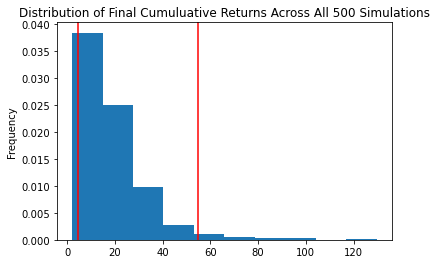

In [27]:
# Plot probability distribution and confidence intervals
monte_carlo_simulation.plot_distribution();

### Retirement Analysis

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
simulation_summary_statistics = monte_carlo_simulation.summarize_cumulative_return()

# Print summary statistics
simulation_summary_statistics

count           500.000000
mean             19.227423
std              14.222752
min               2.118871
25%              10.080776
50%              15.237977
75%              24.357855
max             129.592366
95% CI Lower      4.388703
95% CI Upper     54.838167
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [31]:
# Utility method to get lower and upper confidence interval multiplied by investment
def calulate_ci_range(investment): 
    # Lambda method to calculate investment times CI rounded to two digits by index
    get_ci_by_investment = lambda index: round(investment * simulation_summary_statistics[index], 2)
    # Returning values for lower and upper CI
    return [get_ci_by_investment(8),get_ci_by_investment(9)]

In [32]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower, ci_upper = calulate_ci_range(initial_investment)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $87774.07 and $1096763.33


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [35]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower, ci_upper = calulate_ci_range(initial_investment)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 30 years will end within in the range of $131661.1 and $1645145.0


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
monte_carlo_simulation = MCSimulation(
    portfolio_data = stock_data_df,
    weights = [.1,.9],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
monte_carlo_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.001799  1.000245  1.006243  0.995742  1.003219  0.998395  0.997985   
2     0.998289  1.000243  1.004284  0.996554  1.004502  0.993317  0.996037   
3     1.002639  0.997279  1.008339  0.992870  0.998657  0.989041  0.994189   
4     1.008853  0.996292  1.002813  0.995244  0.996794  0.990576  0.999322   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.438618  0.926659  1.048662  1.101424  1.134443  1.200987  1.347489   
1257  1.441785  0.926428  1.048574  1.104941  1.137374  1.204559  1.360843   
1258  1.444675  0.931714  1.053040  1.110206  1.140592  1.199869  1.358605   
1259  1.443488  0.934065  1.049921  1.108998  1.142538  1.203844  1.363563   
1260  1.446922  0.937697  1.053247  1.107388  1.138983  1.208412  1.364558   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.004253  1.002497  0.998947  ...  1.007121  1.004291  1.000334   
2     1.010316  1.000850  0.996382  ...  1.007016  1.003709  0.999542   
3     1.010062  0.999200  0.999132  ...  1.004156  1.002288  1.003976   
4     1.010897  0.989222  0.995257  ...  1.000057  1.007349  1.006909   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.257520  1.428939  1.194429  ...  1.104654  1.273680  1.276718   
1257  1.260661  1.429710  1.201055  ...  1.107447  1.269262  1.265880   
1258  1.254728  1.426409  1.207420  ...  1.101690  1.274683  1.281527   
1259  1.254192  1.425030  1.213366  ...  1.103902  1.276629  1.275813   
1260  1.243754  1.426672  1.217407  ...  1.103926  1.274986  1.281369   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.000876  0.998973  1.001375  0.996477  1.002103  1.005063  0.995521  
2     1.001450  1.004142  1.004022  0.996702  1.004359  1.009205  0.999000  
3     0.994908  1.008989  1.004545  0.995074  1.010488  1.011124  1.002626  
4     0.990823  1.013085  1.002427  0.996293  1.007081  1.010369  0.998654  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.297344  1.229379  1.295593  1.501864  1.198438  1.386161  1.426163  
1257  1.296800  1.227049  1.297884  1.510874  1.190802  1.388448  1.427391  
1258  1.303255  1.227517  1.294870  1.503567  1.191945  1.388434  1.441467  
1259  1.296929  1.222773  1.285521  1.498580  1.192940  1.397786  1.440244  
1260  1.300069  1.223388  1.283023  1.500150  1.190080  1.398720  1.443262  

[1261 rows x 500 columns]

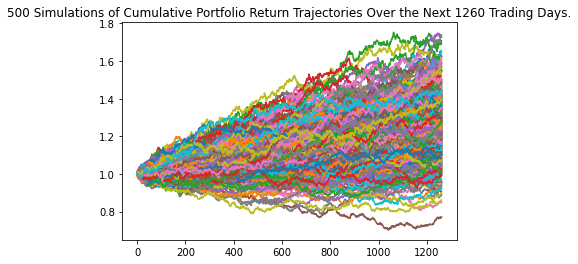

In [26]:
# Plot simulation outcomes
# YOUR CODE HERE!

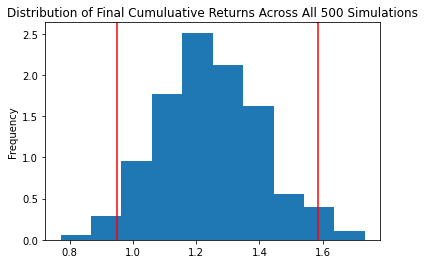

In [27]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.245905
std               0.160008
min               0.771559
25%               1.140795
50%               1.232555
75%               1.352284
max               1.733421
95% CI Lower      0.951523
95% CI Upper      1.586592
Name: 1260, dtype: float64


In [29]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $57091.37 and $95195.55


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
monte_carlo_simulation = MCSimulation(
    portfolio_data = stock_data_df,
    weights = [.1,.9],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.004461  1.003269  0.998934  0.996767  1.000906  0.999279  0.995262   
2     1.007901  1.003304  0.993812  0.999973  1.000910  1.002347  0.996311   
3     1.007532  1.001077  0.990963  0.998339  1.001779  1.003653  0.994439   
4     1.020339  1.005743  0.991869  0.998218  1.005630  1.008717  0.987764   
...        ...       ...       ...       ...       ...       ...       ...   
2516  1.616922  1.761703  1.143430  1.687801  1.743826  1.174891  1.514199   
2517  1.620285  1.769184  1.145132  1.695693  1.742878  1.175745  1.517697   
2518  1.622141  1.771927  1.149019  1.691589  1.739420  1.178965  1.522624   
2519  1.628885  1.770207  1.149670  1.703935  1.738053  1.182429  1.519485   
2520  1.631015  1.770072  1.155133  1.716156  1.740688  1.184901  1.523516   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.005752  0.993466  0.993655  ...  1.001427  1.004350  0.996932   
2     1.007234  0.993550  0.991021  ...  0.997379  1.001952  0.998124   
3     1.012230  0.999170  0.996484  ...  0.995265  1.001745  0.995332   
4     1.012750  0.999227  0.996474  ...  0.999028  1.004730  0.995357   
...        ...       ...       ...  ...       ...       ...       ...   
2516  2.447129  1.589765  1.570578  ...  1.316494  1.863650  1.727959   
2517  2.441471  1.586174  1.560826  ...  1.318463  1.857860  1.724003   
2518  2.444413  1.580680  1.566154  ...  1.317147  1.864694  1.727503   
2519  2.441360  1.565663  1.576607  ...  1.307985  1.858986  1.728039   
2520  2.451787  1.565796  1.574713  ...  1.302946  1.855886  1.730849   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.996844  0.997507  1.003457  0.998736  1.001195  0.999904  1.010218  
2     0.998063  1.001733  1.000273  0.994865  1.000109  0.994648  1.007838  
3     1.003023  1.003800  0.999755  0.997616  1.004730  0.993391  1.010444  
4     1.000204  1.008738  0.999273  0.999426  1.003776  0.991478  1.013379  
...        ...       ...       ...       ...       ...       ...       ...  
2516  1.411033  1.804671  1.500605  1.413278  1.552375  1.318340  1.960015  
2517  1.409092  1.810136  1.499466  1.413210  1.552539  1.316872  1.956776  
2518  1.419561  1.821212  1.492831  1.412283  1.556659  1.318842  1.961271  
2519  1.430017  1.814690  1.496851  1.409284  1.562660  1.324798  1.964190  
2520  1.424173  1.818980  1.496972  1.412152  1.565199  1.320461  1.969683  

[2521 rows x 500 columns]

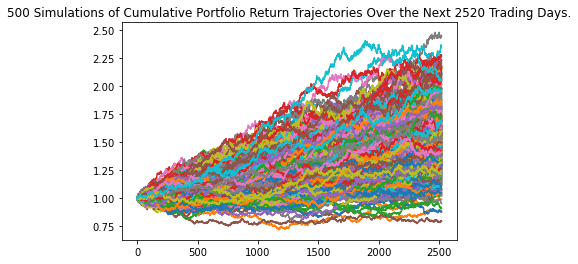

In [32]:
# Plot simulation outcomes
# YOUR CODE HERE!

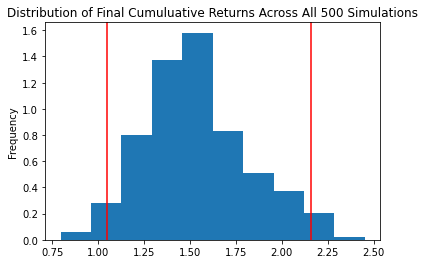

In [33]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.537014
std               0.282192
min               0.795263
25%               1.339641
50%               1.523799
75%               1.693927
max               2.451787
95% CI Lower      1.049781
95% CI Upper      2.159935
Name: 2520, dtype: float64


In [35]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $62986.85 and $129596.12
